# Imports

Packages and photos imports.

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

%matplotlib inline

print(tf.__version__)

2.4.1


On the left the picture that we want to modify and on the left the painting from which we want to transfer the style from. The painting was taken from the training set of out model.

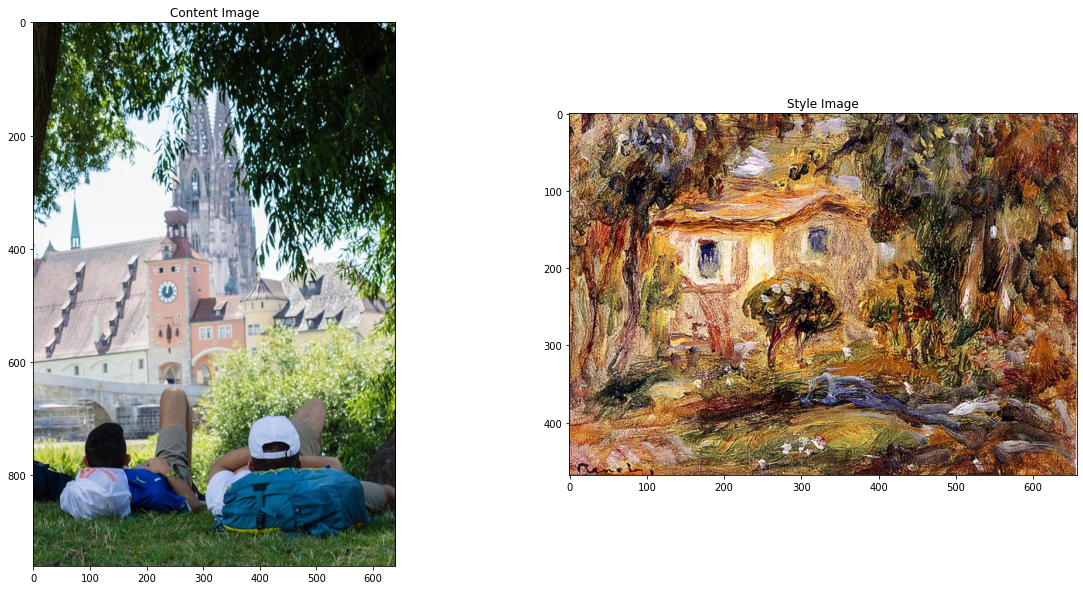

In [9]:
# Load the content and style images
content = plt.imread('drive/MyDrive/Neural Style Transfer/photo.png')
style = plt.imread("drive/MyDrive/Neural Style Transfer/Renoir_Pierre_Auguste_Landscape745.jpg")

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

In [10]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  # img = tf.image.resize(img, [400, 400])
  img = tf.image.resize(img, [256, 256])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [11]:
# Use load_image of content and style images
content = load_image('drive/MyDrive/Neural Style Transfer/photo.png')
style = load_image("drive/MyDrive/Neural Style Transfer/Renoir_Pierre_Auguste_Landscape745.jpg")

# Verify the shapes
content.shape, style.shape

(TensorShape([1, 256, 256, 3]), TensorShape([1, 256, 256, 3]))

# Functions

Set of functions that are going to be later used to perform the style transfer


In [12]:
def mini_model(layer_names, model):

  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([model.input], outputs)
  return model

In [13]:
# Gram matrix
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [14]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, model):
    super(Custom_Style_Model, self).__init__()
    self.model =  mini_model(style_layers + content_layers, model)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.model(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [15]:
# The loss function to optimize
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [16]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

# Training Loop VGG


In the literature the style transfer is normally performed with the VGG19 model. We are going to use it as reference and comparison for our model

In [25]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers, vgg)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [ ]:
# Custom weights for style and content updates
style_weight=100
content_weight=10
total_variation_weight=30

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [ ]:
target_image = tf.Variable(content)

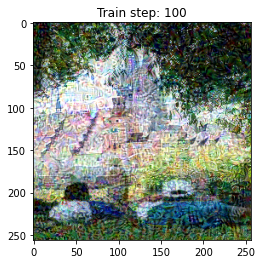

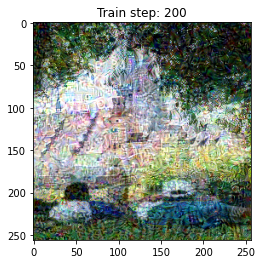

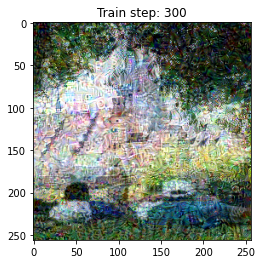

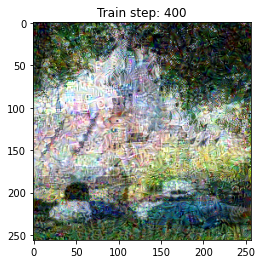

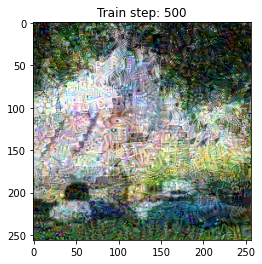

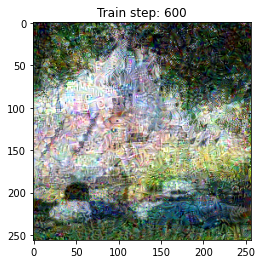

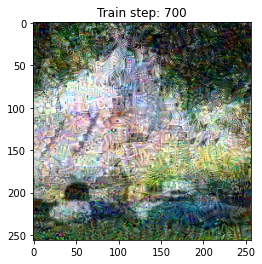

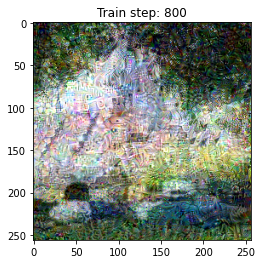

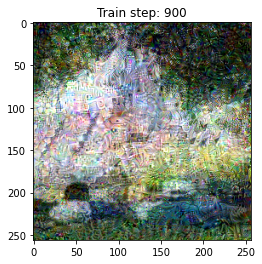

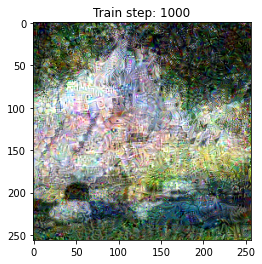

In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

# Model 7

We are going to use our best model in term of performance in the classification task to perform neural style transfer.

In [17]:
model7 = tf.keras.models.load_model('drive/MyDrive/models/cnn_model7.h5')
model7.trainable = False
for layer in model7.layers:
  print(layer.name)

conv2d_40
max_pooling2d_43
conv2d_41
max_pooling2d_44
conv2d_42
max_pooling2d_45
conv2d_43
max_pooling2d_46
conv2d_44
max_pooling2d_47
max_pooling2d_48
flatten_10
dense_23
dense_24
dense_25


At first we set the least deep layers as style layers and the deepest ones as content layers as shown in the literature and with the VGG19 model, but the results are far from ideal

## Neural Style Transfer Loop Model7 layers set as literature


In [18]:
for layer in model7.layers:
  print(layer.name)

conv2d_40
max_pooling2d_43
conv2d_41
max_pooling2d_44
conv2d_42
max_pooling2d_45
conv2d_43
max_pooling2d_46
conv2d_44
max_pooling2d_47
max_pooling2d_48
flatten_10
dense_23
dense_24
dense_25


In [19]:
# Content layer
content_layers = ['conv2d_44']

# Style layer
style_layers = ['conv2d_40']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [20]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers, model7)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [22]:
# Custom weights for style and content updates
style_weight=100
content_weight=10
total_variation_weight=30

# Custom weights for different style layers
style_weights = {'conv2d_40': 1}

In [23]:
target_image = tf.Variable(content)

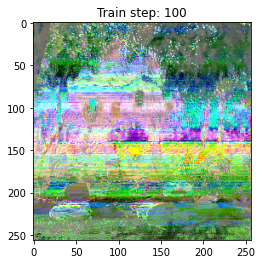

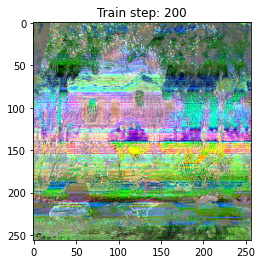

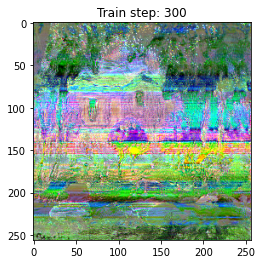

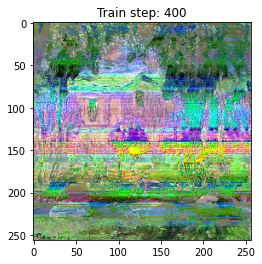

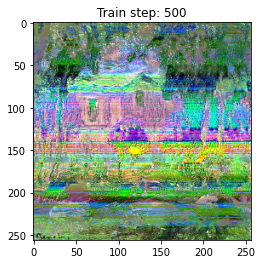

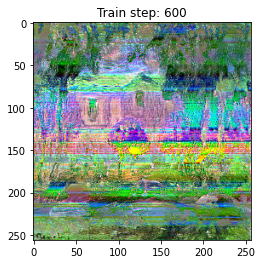

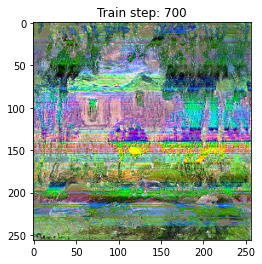

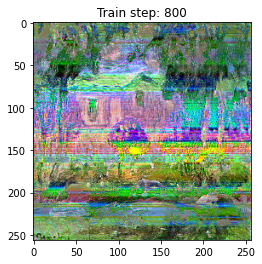

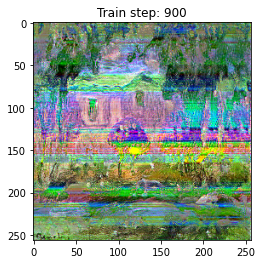

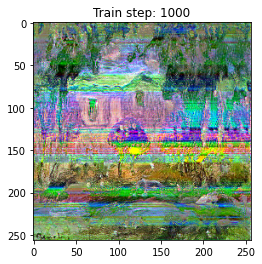

In [24]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

Then we tried several different combinations of weights and layers to understand which layers were better for content and which for style, and this two loops are just the ones with the best results.

## Neural Style Transfer Loop Model7 Experiment 1


In [ ]:
for layer in model7.layers:
  print(layer.name)

conv2d_40
max_pooling2d_43
conv2d_41
max_pooling2d_44
conv2d_42
max_pooling2d_45
conv2d_43
max_pooling2d_46
conv2d_44
max_pooling2d_47
max_pooling2d_48
flatten_10
dense_23
dense_24
dense_25


In [ ]:
# Content layer
content_layers = ['conv2d_40']

# Style layer
style_layers = ['conv2d_44',
                'conv2d_43']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers, model7)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [ ]:
# Custom weights for style and content updates
style_weight=100
content_weight=10
total_variation_weight=30

# Custom weights for different style layers
style_weights = {'conv2d_44': .5,
                 'conv2d_43': .3}

In [ ]:
target_image = tf.Variable(content)

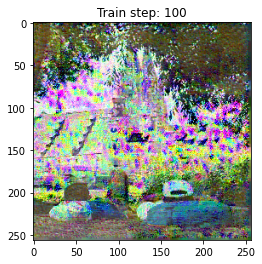

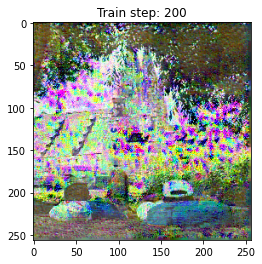

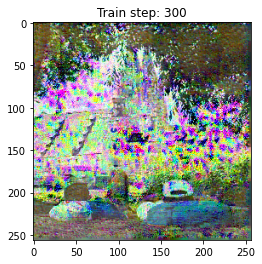

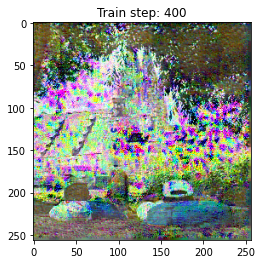

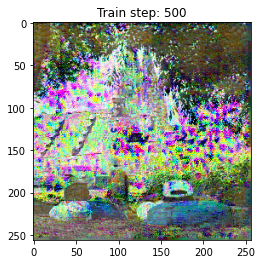

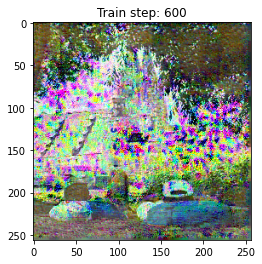

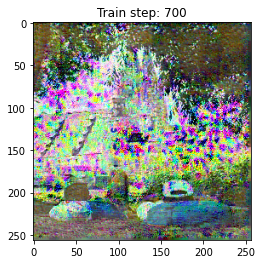

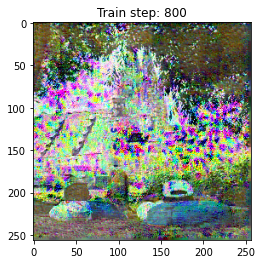

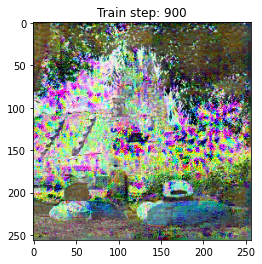

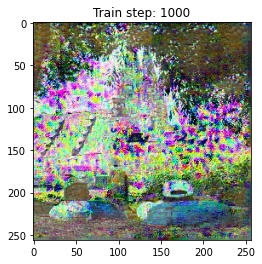

In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

## Neural Style Transfer Loop Model7 Experiment 2


In [ ]:
for layer in model7.layers:
  print(layer.name)

conv2d_40
max_pooling2d_43
conv2d_41
max_pooling2d_44
conv2d_42
max_pooling2d_45
conv2d_43
max_pooling2d_46
conv2d_44
max_pooling2d_47
max_pooling2d_48
flatten_10
dense_23
dense_24
dense_25


In [ ]:
# Content layer
content_layers = ['conv2d_40']

# Style layer
style_layers = ['conv2d_44']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers, model7)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [ ]:
# Custom weights for style and content updates
style_weight=100
content_weight=10
total_variation_weight=30

# Custom weights for different style layers
style_weights = {'conv2d_44': 1.}

In [ ]:
target_image = tf.Variable(content)

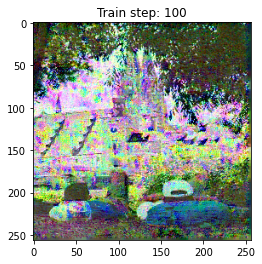

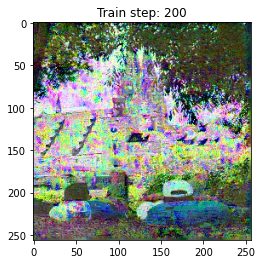

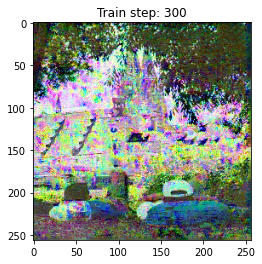

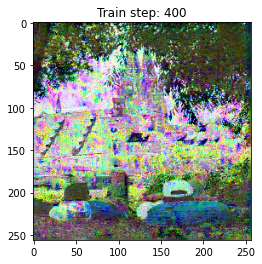

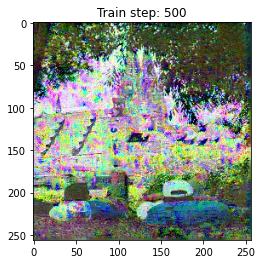

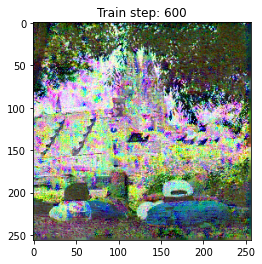

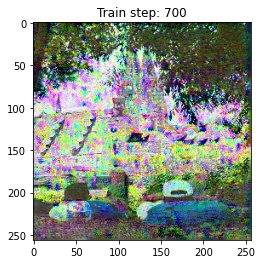

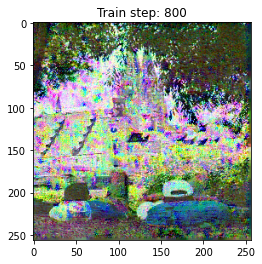

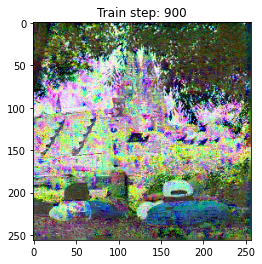

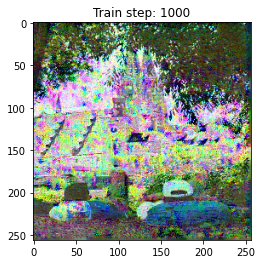

In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()

# Conclusion

In the literature and with the VGG19 model is shown that the deepest layer are the ones that percieve more complex features, therefore the content of the images, and the earlier ones are the ones that are recognize simpler features, therefore the style. Although with our models, as shown in **Neural Style Transfer Loop Best Model 7 layers set as literature** if we set the layers in the order mentioned before, the content  of the style image would be passed down to the content image. There we had to explore different combination of layers and weights, and the best results **Neural Style Transfer Loop Model7 Experiment 1&2** with our model are actually the ones that have the selected layers in the opposite order. So deeper layers for the style and earlier layers for the content. Neural Networks are *black boxes* and therefore almost impossible to interpret, but since our model was trained for a classification task based on the genre, and therefore the style, of the painting, and not the content, this may be why the style is recognized in feature maps(convolutional layers) that are deeper in the model.